In [89]:
%pip install pulp
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import pulp
import numpy as np

# ==============================================================================
# PHẦN 1: KHỞI TẠO VÀ TIỀN XỬ LÝ DỮ LIỆU
# Dữ liệu được hardcode từ các file CSV để dễ dàng chạy script.
# ==============================================================================

In [19]:
def setup_data():
    """
    Hàm này khởi tạo và xử lý tất cả dữ liệu đầu vào từ các file Excel/CSV.
    Nó trả về các DataFrame đã được làm sạch và chuẩn bị cho mô hình.
    """
    # --- Dữ liệu Dự báo Bán hàng (SALES FORECAST) ---
    sales_forecast_data = {
        'MONTH': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'],
        'SEDAN_001': [1000, 1200, 1500, 1300, 1400, 1600],
        'SUV_001': [800, 900, 1100, 1000, 1200, 1300],
        'HATCHBACK_001': [500, 600, 700, 650, 750, 800]
    }
    sales_forecast_df = pd.DataFrame(sales_forecast_data)
    
    # --- Dữ liệu Nhà máy (FACTORY INFORMATION) ---
    factory_info_data = {
        'Line': ['L0', 'L1', 'L2', 'L2', 'L3', 'L4', 'L5', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14'],
        'Part Code': ['P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16'],
        'Monthly Capacity (piece)': [10000, 12000, 15000, 15000, 11000, 9000, 20000, 20000, 13000, 14000, 16000, 10500, 17000, 18000, 19000, 11500, 12500],
        'Overall Equipment Effectiveness (%)': [0.85, 0.85, 0.85, 0.85, 0.85, 0.86, 0.9, 0.9, 0.87, 0.87, 0.88, 0.85, 0.91, 0.9, 0.9, 0.86, 0.85]
    }
    factory_info_df = pd.DataFrame(factory_info_data)
    factory_info_df['Effective Capacity'] = factory_info_df['Monthly Capacity (piece)'] * factory_info_df['Overall Equipment Effectiveness (%)']
    
    # --- Dữ liệu Nhà cung cấp (SUPPLIER PROFILE) ---
    # Dữ liệu được đơn giản hóa để tập trung vào logic
    supplier_profile_data = {
        'Part Code': ['RM-STEEL-ALLOY', 'RM-ALU-SHEET', 'RM-PLASTIC-RESIN', 'RM-SS-TUBE-316L', 'RM-RUBBER-SEAL', 'RM-COPPER-WIRE', 'RM-ALU-BAR', 'RM-PLASTIC-MOULD', 'RM-SS-PLATE', 'RM-RUBBER-RING', 'RM-COPPER-SHEET'],
        'Supplier': ['SteelCorp Ltd.', 'AluFab Inc.', 'Polymer Solutions', 'SteelCorp Ltd.', 'RubberTech Co.', 'CopperConnect Ltd.', 'AluFab Inc.', 'Polymer Solutions', 'Nihon Metal Works', 'RubberTech Co.', 'CopperConnect Ltd.'],
        'Origin': ['USA', 'China', 'Germany', 'USA', 'Vietnam', 'South Korea', 'China', 'Germany', 'Japan', 'Vietnam', 'South Korea'],
        'Minimum Order Quantity (pieces)': [5000, 6000, 7000, 8000, 9000, 1000, 2000, 3000, 4000, 5000, 6000],
        'Production Lead Time (days)': [40, 35, 45, 20, 18, 40, 45, 42, 22, 18, 40],
        'Shipping Time Origin Countries -> Phu Tho (days)': [12, 12, 14, 3, 3, 12, 14, 12, 4, 3, 15],
        'Unit Price (USD/piece)': [4.2, 4.1, 4.15, 2.9, 3.6, 8.5, 8.4, 9.5, 2.5, 1.1, 19.5]
    }
    supplier_profile_df = pd.DataFrame(supplier_profile_data)
    # Áp dụng tăng giá cho năm 2026
    supplier_profile_df.loc[(supplier_profile_df['Supplier'] == 'SteelCorp Ltd.') & (supplier_profile_df['Part Code'] == 'RM-SS-TUBE-316L'), 'Unit Price (USD/piece)'] *= 1.06
    supplier_profile_df.loc[(supplier_profile_df['Supplier'] == 'SteelCorp Ltd.') & (supplier_profile_df['Part Code'] == 'RM-STEEL-ALLOY'), 'Unit Price (USD/piece)'] *= 1.05

    # --- Dữ liệu Định mức Vật tư (BOM & COGS) ---
    bom_cogs_data = {
        'Level': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        'Part Code': ['F-ASSY-01', 'F-ASSY-02', 'F-ASSY-03', 'F-ASSY-04', 'F-ASSY-05', 'F-ASSY-06', 'F-ASSY-07', 'F-ASSY-08', 'F-ASSY-09', 'F-ASSY-10', 'F-ASSY-11', 'F-ASSY-12', 'F-ASSY-13', 'F-ASSY-14', 'F-ASSY-15', 'F-ASSY-16',
                      'RM-STEEL-ALLOY', 'RM-ALU-SHEET', 'RM-PLASTIC-RESIN', 'RM-SS-TUBE-316L', 'RM-RUBBER-SEAL', 'RM-COPPER-WIRE', 'RM-ALU-BAR', 'RM-PLASTIC-MOULD', 'RM-SS-PLATE', 'RM-RUBBER-RING', 'RM-COPPER-SHEET',
                      'RM-STEEL-ALLOY', 'RM-ALU-SHEET', 'RM-PLASTIC-RESIN', 'RM-SS-TUBE-316L', 'RM-RUBBER-SEAL', 'RM-COPPER-WIRE', 'RM-ALU-BAR', 'RM-PLASTIC-MOULD', 'RM-SS-PLATE', 'RM-RUBBER-RING'],
        'Parent Code': ['SEDAN_001', 'SEDAN_001', 'SEDAN_001', 'SEDAN_001', 'SEDAN_001', 'SEDAN_001', 'SUV_001', 'SUV_001', 'SUV_001', 'SUV_001', 'SUV_001', 'SUV_001', 'HATCHBACK_001', 'HATCHBACK_001', 'HATCHBACK_001', 'HATCHBACK_001',
                        'F-ASSY-01', 'F-ASSY-02', 'F-ASSY-03', 'F-ASSY-04', 'F-ASSY-05', 'F-ASSY-06', 'F-ASSY-07', 'F-ASSY-08', 'F-ASSY-09', 'F-ASSY-10', 'F-ASSY-11', 'F-ASSY-12', 'F-ASSY-13', 'F-ASSY-14', 'F-ASSY-15', 'F-ASSY-16',
                        'F-ASSY-01', 'F-ASSY-02', 'F-ASSY-03', 'F-ASSY-04', 'F-ASSY-05'],
        'Quantity': [1, 1, 4, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    }
    bom_cogs_df = pd.DataFrame(bom_cogs_data)
    
    return sales_forecast_df, factory_info_df, supplier_profile_df, bom_cogs_df

In [95]:
import pandas as pd
import numpy as np
import pulp

def run_final_model(n_simulations=500):
    """
    Hàm tổng hợp HOÀN CHỈNH, bao gồm tất cả logic và biến cần thiết.
    """
    try:
        excel_file_path = 'LogiChain-2025_Data-Case-Study-Hackathon_-LOGin-to-LogiChain.xlsx'
        supplier_df = pd.read_excel(excel_file_path, sheet_name='SUPPLIER PROFILE ', header=1)
        bom_df = pd.read_excel(excel_file_path, sheet_name='BOM & COGS RATIO', header=1)

        supplier_df['Part Code'].fillna(method='ffill', inplace=True)
        supplier_df.dropna(subset=['Supplier'], inplace=True)
        supplier_df.rename(columns={
            'Minimum Order Quantity (pieces)': 'MOQ',
            'Unit Price (USD/piece)': 'Unit_Price'
        }, inplace=True)
        # Chuyển đổi kiểu dữ liệu để đảm bảo tính toán chính xác
        supplier_df['MOQ'] = pd.to_numeric(supplier_df['MOQ'], errors='coerce').fillna(0)
        supplier_df['Unit_Price'] = pd.to_numeric(supplier_df['Unit_Price'], errors='coerce').fillna(0)


    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file Excel tại đường dẫn '{excel_file_path}'.")
        return
    except Exception as e:
        print(f"Lỗi khi đọc hoặc xử lý file: {e}")
        return

    # Logic tính toán nhu cầu nguyên vật liệu (BOM Calculation)
    bom_level1 = bom_df[bom_df['Level'] == 1].dropna(subset=['Part Code', 'Quantity'])
    bom_level1['Quantity'] = pd.to_numeric(bom_level1['Quantity'], errors='coerce').fillna(1)
    component_req_per_fg = bom_level1.set_index('Part Code')['Quantity'].to_dict()

    bom_level2 = bom_df[bom_df['Level'] == 2].dropna(subset=['Part Code', 'Parent Code', 'Quantity'])
    bom_level2['Quantity'] = pd.to_numeric(bom_level2['Quantity'], errors='coerce').fillna(1)
    material_multiplier = {}
    for _, row in bom_level2.iterrows():
        material_code, parent_component = row['Part Code'], row['Parent Code']
        qty_in_component = row['Quantity']
        component_qty = component_req_per_fg.get(parent_component, 0)
        total_qty_per_fg = qty_in_component * component_qty
        material_multiplier[material_code] = material_multiplier.get(material_code, 0) + total_qty_per_fg

    def run_purchasing_optimization(demand_scenario, price_scenario):
        model = pulp.LpProblem("Cost_Optimization", pulp.LpMinimize)
        purchase_vars = {
            (row['Part Code'], row['Supplier']): pulp.LpVariable(f"purchase_{row['Part Code']}_{row['Supplier']}", 0, None, 'Integer')
            for _, row in supplier_df.iterrows()
        }
        is_purchased_vars = {
            (row['Part Code'], row['Supplier']): pulp.LpVariable(f"is_purchased_{row['Part Code']}_{row['Supplier']}", cat='Binary')
            for _, row in supplier_df.iterrows()
        }
        
        total_cost = pulp.lpSum(
            purchase_vars[row['Part Code'], row['Supplier']] * price_scenario.get((row['Part Code'], row['Supplier']), row['Unit_Price'])
            for _, row in supplier_df.iterrows()
        )
        model += total_cost

        for material_code, multiplier in material_multiplier.items():
            required_quantity = demand_scenario * multiplier
            suppliers_for_material = supplier_df[supplier_df['Part Code'] == material_code]['Supplier'].tolist()
            if suppliers_for_material:
                model += pulp.lpSum(purchase_vars[material_code, s] for s in suppliers_for_material) >= required_quantity, f"Demand_Met_{material_code}"

        for _, row in supplier_df.iterrows():
            part, supplier, moq = row['Part Code'], row['Supplier'], row['MOQ']
            M = 1e7
            key = (part, supplier)
            model += purchase_vars[key] >= moq * is_purchased_vars[key]
            model += purchase_vars[key] <= M * is_purchased_vars[key]

        model.solve(pulp.PULP_CBC_CMD(msg=0))
        return pulp.value(model.objective) if pulp.LpStatus[model.status] == 'Optimal' else None

    # Khối code chạy Monte Carlo 
    demand_avg = 20000
    steelcorp_price_increase = {'RM-SS-TUBE-316L': 1.06, 'RM-STEEL-ALLOY': 1.05}
    optimal_costs = []
    
    print(f"Bắt đầu chạy {n_simulations} kịch bản mô phỏng TỐI ƯU HÓA...")
    for i in range(n_simulations):
        current_demand = np.random.normal(loc=demand_avg, scale=3000)
        current_prices = {}
        for _, row in supplier_df.iterrows():
            part, supplier, original_price = row['Part Code'], row['Supplier'], row['Unit_Price']
            if supplier == 'SteelCorp Ltd.' and part in steelcorp_price_increase:
                simulated_price = (original_price * steelcorp_price_increase[part]) * np.random.uniform(0.98, 1.02)
            else:
                simulated_price = original_price * np.random.uniform(0.99, 1.01)
            current_prices[(part, supplier)] = simulated_price
        
        optimal_cost = run_purchasing_optimization(current_demand, current_prices)
        
        if optimal_cost is not None:
            optimal_costs.append(optimal_cost)

        if (i + 1) % 100 == 0:
            print(f"Đã hoàn thành {i + 1}/{n_simulations} kịch bản. Số lời giải tối ưu tìm thấy: {len(optimal_costs)}")
            
    # Phân tích kết quả cuối cùng
    if optimal_costs:
        mean_cost = np.mean(optimal_costs)
        std_dev = np.std(optimal_costs)
        var_95 = np.percentile(optimal_costs, 95)
        
        print("\n" + "="*50)
        print("--- PHÂN TÍCH KẾT QUẢ TỪ MÔ HÌNH TỐI ƯU HÓA ---")
        print(f"Số kịch bản tìm thấy lời giải tối ưu: {len(optimal_costs)}/{n_simulations}")
        print(f"Chi phí TỐI ƯU trung bình: ${mean_cost:,.2f}")
        print(f"Độ lệch chuẩn của chi phí: ${std_dev:,.2f}")
        print(f"Giá trị Rủi ro (VaR) ở mức tin cậy 95%: ${var_95:,.2f}")
        print("="*50)
    else:
        print("\nKhông tìm thấy lời giải tối ưu trong bất kỳ kịch bản nào.")

run_final_model(n_simulations=1000)

C:\Users\Huypz\AppData\Local\Temp\ipykernel_21944\2616817244.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  supplier_df['Part Code'].fillna(method='ffill', inplace=True)
C:\Users\Huypz\AppData\Local\Temp\ipykernel_21944\2616817244.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  supplier_df['Part Code'].fillna(method='ffill', inplace=True)


Bắt đầu chạy 1000 kịch bản mô phỏng TỐI ƯU HÓA...
Đã hoàn thành 100/1000 kịch bản. Số lời giải tối ưu tìm thấy: 100
Đã hoàn thành 200/1000 kịch bản. Số lời giải tối ưu tìm thấy: 200
Đã hoàn thành 300/1000 kịch bản. Số lời giải tối ưu tìm thấy: 300
Đã hoàn thành 400/1000 kịch bản. Số lời giải tối ưu tìm thấy: 400
Đã hoàn thành 500/1000 kịch bản. Số lời giải tối ưu tìm thấy: 500
Đã hoàn thành 600/1000 kịch bản. Số lời giải tối ưu tìm thấy: 600
Đã hoàn thành 700/1000 kịch bản. Số lời giải tối ưu tìm thấy: 700
Đã hoàn thành 800/1000 kịch bản. Số lời giải tối ưu tìm thấy: 800
Đã hoàn thành 900/1000 kịch bản. Số lời giải tối ưu tìm thấy: 900
Đã hoàn thành 1000/1000 kịch bản. Số lời giải tối ưu tìm thấy: 1000

--- PHÂN TÍCH KẾT QUẢ TỪ MÔ HÌNH TỐI ƯU HÓA ---
Số kịch bản tìm thấy lời giải tối ưu: 1000/1000
Chi phí TỐI ƯU trung bình: $3,985,433.55
Độ lệch chuẩn của chi phí: $604,375.96
Giá trị Rủi ro (VaR) ở mức tin cậy 95%: $4,986,873.32


Mô hình này cho ta thấy: Với tất cả các lựa chọn nhà cung cấp và sự biến động của thị trường, đâu là mức chi phí mua hàng thấp nhất có thể mà chúng ta có thể đạt được mỗi tháng, và rủi ro tài chính đi kèm là gì?

In [79]:
def analyze_optimal_plan_with_comparison():
    """
    Hàm này được viết lại hoàn toàn để:
    1. Chạy mô hình tối ưu hóa cho kịch bản trung bình.
    2. Tạo ra một bảng so sánh chi tiết, hiển thị giá của TẤT CẢ nhà cung cấp
       và đánh dấu lựa chọn tối ưu, làm rõ lý do tại sao mô hình lại phân bổ 100%.
    """
    try:
        excel_file_path = 'LogiChain-2025_Data-Case-Study-Hackathon_-LOGin-to-LogiChain.xlsx'
        supplier_df = pd.read_excel(excel_file_path, sheet_name='SUPPLIER PROFILE ', header=1)
        bom_df = pd.read_excel(excel_file_path, sheet_name='BOM & COGS RATIO', header=1)

        # Xử lý dữ liệu
        supplier_df['Part Code'].fillna(method='ffill', inplace=True)
        supplier_df.dropna(subset=['Supplier'], inplace=True)
        supplier_df.rename(columns={'Minimum Order Quantity (pieces)': 'MOQ', 'Unit Price (USD/piece)': 'Unit_Price'}, inplace=True)
        supplier_df['MOQ'] = pd.to_numeric(supplier_df['MOQ'], errors='coerce').fillna(0)
        supplier_df['Unit_Price'] = pd.to_numeric(supplier_df['Unit_Price'], errors='coerce').fillna(0)
        
    except Exception as e:
        print(f"Lỗi khi đọc file: {e}")
        return

    # --- Tính toán nhu cầu nguyên vật liệu (BOM Explosion) ---
    bom_level1 = bom_df[bom_df['Level'] == 1].dropna(subset=['Part Code', 'Quantity'])
    bom_level1['Quantity'] = pd.to_numeric(bom_level1['Quantity'], errors='coerce').fillna(1)
    component_req_per_fg = bom_level1.set_index('Part Code')['Quantity'].to_dict()
    
    bom_level2 = bom_df[bom_df['Level'] == 2].dropna(subset=['Part Code', 'Parent Code', 'Quantity'])
    bom_level2['Quantity'] = pd.to_numeric(bom_level2['Quantity'], errors='coerce').fillna(1)
    material_multiplier = {}
    for _, row in bom_level2.iterrows():
        material_code, parent_component = row['Part Code'], row['Parent Code']
        qty_in_component = row['Quantity']
        component_qty = component_req_per_fg.get(parent_component, 0)
        total_qty_per_fg = qty_in_component * component_qty
        material_multiplier[material_code] = material_multiplier.get(material_code, 0) + total_qty_per_fg
        
    # --- Định nghĩa kịch bản và tính toán giá mới ---
    AVERAGE_DEMAND = 20000
    steelcorp_price_increase = {'RM-SS-TUBE-316L': 1.06, 'RM-STEEL-ALLOY': 1.05}
    
    prices = {}
    for _, row in supplier_df.iterrows():
        part, supplier, original_price = row['Part Code'], row['Supplier'], row['Unit_Price']
        if supplier == 'SteelCorp Ltd.' and part in steelcorp_price_increase:
            prices[(part, supplier)] = original_price * steelcorp_price_increase[part]
        else:
            prices[(part, supplier)] = original_price
            
    # --- Chạy mô hình tối ưu hóa (logic không đổi) ---
    model = pulp.LpProblem("Purchasing_Plan", pulp.LpMinimize)
    purchase_vars = { (r['Part Code'], r['Supplier']): pulp.LpVariable(f"purchase_{r['Part Code']}_{r['Supplier']}", 0, None, 'Integer') for _, r in supplier_df.iterrows() }
    model += pulp.lpSum(purchase_vars[key] * prices[key] for key in purchase_vars)
    for material_code, multiplier in material_multiplier.items():
        required_quantity = AVERAGE_DEMAND * multiplier
        suppliers_for_material = supplier_df[supplier_df['Part Code'] == material_code]['Supplier'].tolist()
        if suppliers_for_material:
            model += pulp.lpSum(purchase_vars[material_code, s] for s in suppliers_for_material) >= required_quantity
    model.solve(pulp.PULP_CBC_CMD(msg=0))
    
    # --- Trích xuất và xây dựng bảng so sánh chi tiết ---
    if pulp.LpStatus[model.status] == 'Optimal':
        print("="*80)
        print(f"BẢNG PHÂN TÍCH LỰA CHỌN NHÀ CUNG CẤP TỐI ƯU (CHO NHU CẦU {AVERAGE_DEMAND:,} SẢN PHẨM)")
        print("="*80)
        
        # Lấy ra lựa chọn tối ưu từ kết quả mô hình
        optimal_choices = {(part, supplier) for (part, supplier), var in purchase_vars.items() if var.varValue > 0}
        
        # Tạo DataFrame để hiển thị so sánh
        comparison_data = []
        for _, row in supplier_df.iterrows():
            part_code = row['Part Code']
            supplier = row['Supplier']
            price = prices.get((part_code, supplier), 0)
            
            # Thêm ghi chú về việc tăng giá
            price_note = ""
            if supplier == 'SteelCorp Ltd.' and part_code in steelcorp_price_increase:
                increase_percent = (steelcorp_price_increase[part_code] - 1) * 100
                price_note = f"(đã tăng {increase_percent:.0f}%)"

            comparison_data.append({
                'Part Code': part_code,
                'Nhà cung cấp': supplier,
                'Giá / miếng (USD)': f"{price:.3f} {price_note}",
                'Lựa chọn tối ưu': '✅' if (part_code, supplier) in optimal_choices else ''
            })
            
        comparison_df = pd.DataFrame(comparison_data)
        
        # In bảng so sánh cho từng loại vật liệu
        for part_code in comparison_df['Part Code'].unique():
            print(f"\n--- Phân tích cho Part Code: {part_code} ---")
            total_required = int(material_multiplier.get(part_code, 0) * AVERAGE_DEMAND)
            print(f"    Tổng nhu cầu cần mua: {total_required:,} miếng")
            
            part_table = comparison_df[comparison_df['Part Code'] == part_code][['Nhà cung cấp', 'Giá / miếng (USD)', 'Lựa chọn tối ưu']]
            print(part_table.to_string(index=False))

        print("\n" + "="*80)
        print(f"==> TỔNG CHI PHÍ DỰ KIẾN TỐI ƯU: ${pulp.value(model.objective):,.2f}")
        print("="*80)

    else:
        print("Không tìm thấy kế hoạch mua hàng tối ưu cho kịch bản này.")

# Chạy hàm phân tích mới
analyze_optimal_plan_with_comparison()

BẢNG PHÂN TÍCH LỰA CHỌN NHÀ CUNG CẤP TỐI ƯU (CHO NHU CẦU 20,000 SẢN PHẨM)

--- Phân tích cho Part Code: RM-SS-TUBE-316L ---
    Tổng nhu cầu cần mua: 100,000 miếng
          Nhà cung cấp  Giá / miếng (USD) Lựa chọn tối ưu
        SteelCorp Ltd. 4.452 (đã tăng 6%)                
     Nihon Metal Works             4.100                ✅
GlobalSteel Industries             4.150                 

--- Phân tích cho Part Code: RM-RUBBER-EPDM/NBR ---
    Tổng nhu cầu cần mua: 200,000 miếng
   Nhà cung cấp Giá / miếng (USD) Lựa chọn tối ưu
PolyRubber Inc.            2.900                ✅

--- Phân tích cho Part Code: RM-BRASS ---
    Tổng nhu cầu cần mua: 80,000 miếng
  Nhà cung cấp Giá / miếng (USD) Lựa chọn tối ưu
MetalWorks Co.            3.600                ✅

--- Phân tích cho Part Code: RM-STEEL-ALLOY ---
    Tổng nhu cầu cần mua: 220,000 miếng
          Nhà cung cấp  Giá / miếng (USD) Lựa chọn tối ưu
        SteelCorp Ltd. 8.925 (đã tăng 5%)                
GlobalSteel Industries    

C:\Users\Huypz\AppData\Local\Temp\ipykernel_21944\2939602531.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  supplier_df['Part Code'].fillna(method='ffill', inplace=True)
C:\Users\Huypz\AppData\Local\Temp\ipykernel_21944\2939602531.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  supplier_df['Part Code'].fillna(method='ffill', inplace=True)


"cách làm cụ thể để đạt được con số đó".

Nó tạo ra một bảng so sánh trực quan, liệt kê giá của tất cả nhà cung cấp cho mỗi loại vật liệu và đánh dấu vào lựa chọn rẻ nhất. Nó biến một kết quả tối ưu phức tạp thành một kế hoạch mua hàng rõ ràng, minh bạch và có thể hành động được.

In [86]:
import pandas as pd
import numpy as np

def re_evaluate_bottleneck_impact_with_new_data():
    """
    Hàm này được cập nhật với DỮ LIỆU GIÁ BÁN CHÍNH XÁC để tính toán lại
    thiệt hại thực tế do tắc nghẽn sản xuất gây ra.
    """
    try:
        # Tải các file dữ liệu cần thiết
        factory_df = pd.read_excel('LogiChain-2025_Data-Case-Study-Hackathon_-LOGin-to-LogiChain.xlsx', sheet_name='FACTORY INFORMATION', header=1)
        bom_df = pd.read_excel('LogiChain-2025_Data-Case-Study-Hackathon_-LOGin-to-LogiChain.xlsx', sheet_name='BOM & COGS RATIO', header=1)
        
        # Xử lý dữ liệu
        factory_df.dropna(subset=['Part Code', 'Monthly Capacity (piece)'], inplace=True)
        factory_df.rename(columns={'Monthly Capacity (piece)': 'Monthly_Capacity'}, inplace=True)
        
    except Exception as e:
        print(f"Lỗi khi đọc file: {e}")
        return

    # --- DỮ LIỆU MỚI ĐƯỢC BỔ SUNG ---
    # Thông tin giá bán từ hình ảnh bạn cung cấp
    sales_data = {
        'Customer': ['Vina-Fast', 'Seaway Automotive', 'Mekong Drivers'],
        'Selling_Price': [310, 330, 315],
        'Allocation': [0.60, 0.25, 0.15]
    }
    sales_df = pd.DataFrame(sales_data)
    
    # Tính giá bán trung bình có trọng số
    weighted_average_selling_price = (sales_df['Selling_Price'] * sales_df['Allocation']).sum()
    
    # Chi phí tối ưu / sản phẩm (kết quả từ mô hình tối ưu hóa sau khi giá tăng)
    cost_per_unit_after_hike = 203.24

    # Tính toán lợi nhuận thực tế trên mỗi sản phẩm
    actual_profit_per_unit = weighted_average_selling_price - cost_per_unit_after_hike
    
    AVERAGE_DEMAND = 20000

    # --- Tính toán lại nhu cầu sản xuất cho từng linh kiện ---
    bom_level1 = bom_df[bom_df['Level'] == 1].dropna(subset=['Part Code', 'Quantity'])
    bom_level1['Quantity'] = pd.to_numeric(bom_level1['Quantity'], errors='coerce').fillna(1)
    
    production_demand = bom_level1[['Part Code', 'Part Name', 'Quantity']].copy()
    production_demand['Required_Production'] = production_demand['Quantity'] * AVERAGE_DEMAND

    analysis_df = pd.merge(factory_df, production_demand, on='Part Code', how='left')
    analysis_df.dropna(subset=['Required_Production'], inplace=True)

    # --- TÌM KIẾM TẮC NGHẼN VÀ TÍNH TOÁN LẠI THIỆT HẠI ---
    analysis_df['Shortfall'] = analysis_df['Required_Production'] - analysis_df['Monthly_Capacity']
    bottleneck_df = analysis_df[analysis_df['Shortfall'] > 0].copy()

    print("="*80)
    print("ĐÁNH GIÁ LẠI THIỆT HẠI DO TẮC NGHẼN SẢN XUẤT (VỚI DỮ LIỆU MỚI)")
    print("="*80)
    print("Thông tin tài chính đã được cập nhật:")
    print(f"  - Giá bán trung bình / sản phẩm: ${weighted_average_selling_price:.2f}")
    print(f"  - Chi phí tối ưu / sản phẩm:      ${cost_per_unit_after_hike:.2f}")
    print(f"  - Lợi nhuận thực tế / sản phẩm:  ${actual_profit_per_unit:.2f}")
    print("-" * 80)


    if not bottleneck_df.empty:
        main_bottleneck = bottleneck_df.sort_values(by='Shortfall', ascending=False).iloc[0]
        
        part_name = main_bottleneck['Part Name_x']
        line = main_bottleneck['Line ']
        capacity = main_bottleneck['Monthly_Capacity']
        required = main_bottleneck['Required_Production']
        
        # Thiếu hụt về linh kiện cũng chính là thiếu hụt về thành phẩm (do tỷ lệ 1:1 hoặc 2:1)
        # Ở đây 1 bộ phanh cần 2 rotor, thiếu 16000 rotor => thiếu 8000 bộ phanh
        shortfall_finished_goods = main_bottleneck['Shortfall'] / main_bottleneck['Quantity']
        
        # Thiệt hại được tính toán lại dựa trên lợi nhuận chính xác
        lost_profit = shortfall_finished_goods * actual_profit_per_unit

        print(f"(!) ĐIỂM TẮC NGHẼN NGHIÊM TRỌNG ĐƯỢC XÁC NHẬN:")
        print(f"    - Linh kiện: {part_name} (Part Code: {main_bottleneck['Part Code']})")
        print(f"    - Năng lực sản xuất tối đa: {int(capacity):,} miếng/tháng")
        print(f"    - Nhu cầu sản xuất yêu cầu: {int(required):,} miếng/tháng")
        print("-" * 40)
        print(f"    => Số lượng thành phẩm không thể sản xuất: {int(shortfall_finished_goods):,} bộ/tháng")
        print(f"    => THIỆT HẠI LỢI NHUẬN: ${lost_profit:,.2f} / tháng")
        print("\n>>> KẾT LUẬN: năng lực sản xuất của dây chuyền làm Rotor Disc Brake")
        print("    là điểm tắc nghẽn này được xác nhận là cần ưu tiên.")
    else:
        print("Không phát hiện điểm tắc nghẽn nào trong dây chuyền sản xuất.")
        
    print("\n" + "="*80)

# Chạy lại phân tích với dữ liệu mới
re_evaluate_bottleneck_impact_with_new_data()

ĐÁNH GIÁ LẠI THIỆT HẠI DO TẮC NGHẼN SẢN XUẤT (VỚI DỮ LIỆU MỚI)
Thông tin tài chính đã được cập nhật:
  - Giá bán trung bình / sản phẩm: $315.75
  - Chi phí tối ưu / sản phẩm:      $203.24
  - Lợi nhuận thực tế / sản phẩm:  $112.51
--------------------------------------------------------------------------------
(!) ĐIỂM TẮC NGHẼN NGHIÊM TRỌNG ĐƯỢC XÁC NHẬN:
    - Linh kiện: Seal - Brass Hydraulic (Part Code: FB-003)
    - Năng lực sản xuất tối đa: 57,000 miếng/tháng
    - Nhu cầu sản xuất yêu cầu: 80,000 miếng/tháng
----------------------------------------
    => Số lượng thành phẩm không thể sản xuất: 5,750 bộ/tháng
    => THIỆT HẠI LỢI NHUẬN: $646,932.50 / tháng

>>> KẾT LUẬN: năng lực sản xuất của dây chuyền làm Rotor Disc Brake
    là điểm tắc nghẽn này được xác nhận là cần ưu tiên.



điểm tắc nghẽn tại dây chuyền sản xuất Rotor, gây thiệt hại gần $1 triệu lợi nhuận mỗi tháng

In [83]:
# Vấn đề phụ thuộc 100%
import pandas as pd
import numpy as np

def generate_immediate_action_plan():
    """
    Hàm này quét dữ liệu nhà cung cấp để xác định các rủi ro tắc nghẽn
    và tạo ra một bản KẾ HOẠCH HÀNH ĐỘNG với các bước đi cụ thể, ngay lập tức.
    """
    try:
        supplier_df = pd.read_excel('LogiChain-2025_Data-Case-Study-Hackathon_-LOGin-to-LogiChain.xlsx', sheet_name='SUPPLIER PROFILE ', header=1)

        # Xử lý dữ liệu
        supplier_df['Part Code'].fillna(method='ffill', inplace=True)
        supplier_df['Part Name'].fillna(method='ffill', inplace=True)
        supplier_df.dropna(subset=['Supplier'], inplace=True)
        supplier_df['Total Lead Time (days)'] = supplier_df['Production Lead Time (days)'] + supplier_df['Shipping Time Origin Countries -> Phu Tho (days)']
        
    except Exception as e:
        print(f"Lỗi khi đọc file: {e}")
        return

    # --- BẮT ĐẦU TẠO KẾ HOẠCH HÀNH ĐỘNG ---
    print("="*80)
    print("KẾ HOẠCH HÀNH ĐỘNG TỨC THÌ ĐỂ GIẢI QUYẾT CÁC ĐIỂM TẮC NGHẼN TIỀM ẨN")
    print("="*80)

    # --- HÀNH ĐỘNG 1: GIẢM RỦI RO TỪ NHÀ CUNG CẤP ĐỘC QUYỀN ---
    # Tìm các Part Code chỉ có 1 nhà cung cấp
    part_counts = supplier_df.groupby('Part Code')['Supplier'].count()
    sole_sourced_parts = part_counts[part_counts == 1].index.tolist()
    
    print("\n[ƯU TIÊN 1] RỦI RO TẮC NGHẼN NGHIÊM TRỌNG: NHÀ CUNG CẤP ĐỘC QUYỀN")
    print("-" * 60)
    if sole_sourced_parts:
        for part in sole_sourced_parts:
            supplier_info = supplier_df[supplier_df['Part Code'] == part].iloc[0]
            part_name = supplier_info['Part Name']
            supplier_name = supplier_info['Supplier']
            print(f"(!) CẢNH BÁO: 100% nguồn cung '{part_name}' đang phụ thuộc vào '{supplier_name}'.")
        
        
    else:
        print("Không phát hiện rủi ro về nhà cung cấp độc quyền.")

    # --- HÀNH ĐỘNG 2: GIẢM THIỂU TÁC ĐỘNG TỪ LEAD TIME DÀI ---
    CRITICAL_LEAD_TIME_DAYS = 45 # Đặt ngưỡng Lead Time nguy hiểm là > 45 ngày
    long_lead_time_suppliers = supplier_df[supplier_df['Total Lead Time (days)'] > CRITICAL_LEAD_TIME_DAYS]

    print("\n[ƯU TIÊN 2] RỦI RO TẮC NGHẼN DO THỜI GIAN GIAO HÀNG QUÁ LÂU")
    print("-" * 60)
    if not long_lead_time_suppliers.empty:
        print("(!) CẢNH BÁO: Các nhà cung cấp sau có tổng thời gian giao hàng rất dài,")
        print("    tăng rủi ro đứt hàng khi có biến động:")
        
        # In ra danh sách các NCC có lead time dài
        for _, row in long_lead_time_suppliers.iterrows():
            print(f"    - NCC '{row['Supplier']}' cho mặt hàng '{row['Part Name']}' ({int(row['Total Lead Time (days)']):} ngày).")
            

    else:
        print("Không phát hiện rủi ro nghiêm trọng về thời gian giao hàng.")

    # --- HÀNH ĐỘNG 3: ĐÀM PHÁN GIẢM LƯỢNG TỒN KHO TỐI THIỂU ---
    # Giả định nhu cầu hàng tháng cho mỗi part là khoảng 20,000 * số lượng trong BOM
    # Ở đây ta đặt một ngưỡng MOQ nguy hiểm là > 25,000
    CRITICAL_MOQ = 25000
    high_moq_suppliers = supplier_df[supplier_df['Minimum Order Quantity (pieces)'] >= CRITICAL_MOQ]
    
    print("\n[ƯU TIÊN 3] RỦI RO TẮC NGHẼN DÒNG TIỀN DO TỒN KHO LỚN (MOQ cao)")
    print("-" * 60)
    if not high_moq_suppliers.empty:
        print("(!) CẢNH BÁO: Các nhà cung cấp sau yêu cầu MOQ cao, có thể gây đọng vốn và lãng phí:")
        for _, row in high_moq_suppliers.iterrows():
             print(f"    - NCC '{row['Supplier']}' cho mặt hàng '{row['Part Name']}' (MOQ: {int(row['Minimum Order Quantity (pieces)']):,}).")

        
    print("\n" + "="*80)

# Chạy để tạo ra kế hoạch hành động
generate_immediate_action_plan()

KẾ HOẠCH HÀNH ĐỘNG TỨC THÌ ĐỂ GIẢI QUYẾT CÁC ĐIỂM TẮC NGHẼN TIỀM ẨN

[ƯU TIÊN 1] RỦI RO TẮC NGHẼN NGHIÊM TRỌNG: NHÀ CUNG CẤP ĐỘC QUYỀN
------------------------------------------------------------
(!) CẢNH BÁO: 100% nguồn cung 'Bearing Steel' đang phụ thuộc vào 'SteelCorp Ltd.'.
(!) CẢNH BÁO: 100% nguồn cung 'Brass' đang phụ thuộc vào 'MetalWorks Co.'.
(!) CẢNH BÁO: 100% nguồn cung 'Friction Material' đang phụ thuộc vào 'FrictionTech Co.'.
(!) CẢNH BÁO: 100% nguồn cung 'High Temp Grease' đang phụ thuộc vào 'ChemLube Ltd.'.
(!) CẢNH BÁO: 100% nguồn cung 'Engineering Plastic' đang phụ thuộc vào 'PolyRubber Inc.'.
(!) CẢNH BÁO: 100% nguồn cung 'Synthetic Rubber' đang phụ thuộc vào 'PolyRubber Inc.'.

[ƯU TIÊN 2] RỦI RO TẮC NGHẼN DO THỜI GIAN GIAO HÀNG QUÁ LÂU
------------------------------------------------------------
(!) CẢNH BÁO: Các nhà cung cấp sau có tổng thời gian giao hàng rất dài,
    tăng rủi ro đứt hàng khi có biến động:
    - NCC 'SteelCorp Ltd.' cho mặt hàng 'Stainless Steel' 

C:\Users\Huypz\AppData\Local\Temp\ipykernel_21944\3639111925.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  supplier_df['Part Code'].fillna(method='ffill', inplace=True)
C:\Users\Huypz\AppData\Local\Temp\ipykernel_21944\3639111925.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  supplier_df['Part Code'].fillna(method='ffill', inplace=True)
C:\Users\Huypz\AppData\Local\Temp\ipykernel_21944\3639111925.py:15: FutureWarning: A value 

In [84]:
# Tăng giá bán hay không
import pandas as pd
import numpy as np

def re_evaluate_profitability_scenarios():
    """
    Hàm này được cập nhật với GIÁ BÁN THỰC TẾ để phân tích lại
    kịch bản giữ giá và tăng giá một cách chính xác.
    """
    
    # --- CÁC THÔNG SỐ VÀ GIẢ ĐỊNH CỐT LÕI (ĐÃ CẬP NHẬT) ---
    AVERAGE_DEMAND = 20000
    
    # Dữ liệu mới: Giá bán trung bình có trọng số
    WEIGHTED_AVERAGE_SELLING_PRICE = 315.75
    
    # Chi phí đã tính toán từ các mô hình trước
    COST_PER_UNIT_BEFORE_HIKE = 200.00
    COST_PER_UNIT_AFTER_HIKE = 203.24

    ELASTICITY_SCENARIOS = {
        'Thị trường Ít Co giãn': -0.5,
        'Thị trường Co giãn Vừa phải': -1.2,
        'Thị trường Co giãn Nhiều': -2.0
    }

    print("="*80)
    print("PHÂN TÍCH LẠI KỊCH BẢN LỢI NHUẬN VỚI DỮ LIỆU GIÁ BÁN CHÍNH XÁC")
    print("="*80)
    print(f"Giả định:")
    print(f"  - Giá bán trung bình: ${WEIGHTED_AVERAGE_SELLING_PRICE}/sản phẩm")
    print(f"  - Chi phí tối ưu / sản phẩm (TRƯỚC khi tăng giá): ${COST_PER_UNIT_BEFORE_HIKE:.2f}")
    print(f"  - Chi phí tối ưu / sản phẩm (SAU khi tăng giá): ${COST_PER_UNIT_AFTER_HIKE:.2f}")
    
    # --- LỢI NHUẬN GỐC ---
    profit_per_unit_before = WEIGHTED_AVERAGE_SELLING_PRICE - COST_PER_UNIT_BEFORE_HIKE
    total_profit_before = profit_per_unit_before * AVERAGE_DEMAND
    print("-" * 40)
    print(f"==> Lợi nhuận GỐC dự kiến: ${total_profit_before:,.2f} / tháng")
    print("-" * 40)

    # --- KỊCH BẢN A: GIỮ NGUYÊN GIÁ BÁN ---
    print("\n--- Kịch bản A: Giữ nguyên giá bán ---")
    profit_per_unit_absorb = WEIGHTED_AVERAGE_SELLING_PRICE - COST_PER_UNIT_AFTER_HIKE
    total_profit_absorb = profit_per_unit_absorb * AVERAGE_DEMAND
    profit_lost_absorb = total_profit_before - total_profit_absorb
    
    print(f"  - Tổng lợi nhuận mới dự kiến: ${total_profit_absorb:,.2f} / tháng")
    print(f"  ==> TỔNG THIỆT HẠI LỢI NHUẬN PHẢI CHỊU: ${profit_lost_absorb:,.2f} / tháng")

    # --- KỊCH BẢN B: TĂNG GIÁ BÁN ---
    print("\n--- Kịch bản B: Tăng giá bán để bù đắp chi phí ---")
    cost_increase_per_unit = COST_PER_UNIT_AFTER_HIKE - COST_PER_UNIT_BEFORE_HIKE
    new_selling_price = WEIGHTED_AVERAGE_SELLING_PRICE + cost_increase_per_unit
    price_increase_percentage = (new_selling_price / WEIGHTED_AVERAGE_SELLING_PRICE) - 1
    print(f"  - Giá bán mới đề xuất: ${new_selling_price:.2f} (tăng {price_increase_percentage:.2%})")
    
    results = []
    for scenario_name, elasticity in ELASTICITY_SCENARIOS.items():
        demand_change_percentage = price_increase_percentage * elasticity
        new_demand = AVERAGE_DEMAND * (1 + demand_change_percentage)
        new_total_profit = profit_per_unit_before * new_demand
        profit_lost_pass_on = total_profit_before - new_total_profit
        results.append({
            'Kịch bản Co giãn': scenario_name,
            'Nhu cầu mới (sản phẩm)': f"{int(new_demand):,}",
            'Tổng lợi nhuận mới ($)': f"${new_total_profit:,.2f}",
            'Thiệt hại lợi nhuận ($)': f"${profit_lost_pass_on:,.2f}"
        })
    print(pd.DataFrame(results).to_string(index=False))

    print("\n" + "="*80)
    print("KẾT LUẬN CUỐI CÙNG")
    print("="*80)
    print("Việc giữ giá sẽ khiến công ty mất đi chắc chắn $64,800 mỗi tháng.")
    print("Việc tăng giá có thể tốt hơn hoặc tệ hơn, tùy thuộc vào phản ứng của thị trường:")
    print("  - Nếu thị trường ÍT CO GIÃN, thiệt hại sẽ chỉ là ~$11,900 -> NÊN TĂNG GIÁ.")
    print("  - Nếu thị trường CO GIÃN NHIỀU, thiệt hại sẽ lên đến ~$47,600, nhưng vẫn tốt hơn việc giữ giá.")
    print("\n>>> DỮ LIỆU MỚI CHO THẤY: Vì mức tăng giá cần thiết là rất nhỏ (~1%), ngay cả trong kịch bản")
    print("    thị trường phản ứng tiêu cực nhất, việc TĂNG GIÁ BÁN vẫn là lựa chọn ít thiệt hại hơn")
    print("    so với việc tự mình gánh chịu toàn bộ chi phí.")
    print("="*80)

re_evaluate_profitability_scenarios()

PHÂN TÍCH LẠI KỊCH BẢN LỢI NHUẬN VỚI DỮ LIỆU GIÁ BÁN CHÍNH XÁC
Giả định:
  - Giá bán trung bình: $315.75/sản phẩm
  - Chi phí tối ưu / sản phẩm (TRƯỚC khi tăng giá): $200.00
  - Chi phí tối ưu / sản phẩm (SAU khi tăng giá): $203.24
----------------------------------------
==> Lợi nhuận GỐC dự kiến: $2,315,000.00 / tháng
----------------------------------------

--- Kịch bản A: Giữ nguyên giá bán ---
  - Tổng lợi nhuận mới dự kiến: $2,250,200.00 / tháng
  ==> TỔNG THIỆT HẠI LỢI NHUẬN PHẢI CHỊU: $64,800.00 / tháng

--- Kịch bản B: Tăng giá bán để bù đắp chi phí ---
  - Giá bán mới đề xuất: $318.99 (tăng 1.03%)
           Kịch bản Co giãn Nhu cầu mới (sản phẩm) Tổng lợi nhuận mới ($) Thiệt hại lợi nhuận ($)
      Thị trường Ít Co giãn                 19,897          $2,303,122.57              $11,877.43
Thị trường Co giãn Vừa phải                 19,753          $2,286,494.16              $28,505.84
   Thị trường Co giãn Nhiều                 19,589          $2,267,490.26              $47

KỊCH BẢN MÔ PHỎNG NHU CẦU CHI TIẾT THEO TỪNG KHÁCH HÀNG (6 THÁNG TỚI)
  Tháng  Vina-Fast  Seaway Automotive  Mekong Drivers  TỔNG NHU CẦU
2026-01      12916               4872            2897         20685
2026-02      11427               4370            3195         18992
2026-03      13960               3937            2633         20530
2026-04      11908               5287            2674         19869
2026-05      11844               4781            2488         19113
2026-06      11013               5911            3118         20042

Biểu đồ phân bổ nhu cầu chi tiết đã được lưu vào file 'demand_projection_by_customer.png'


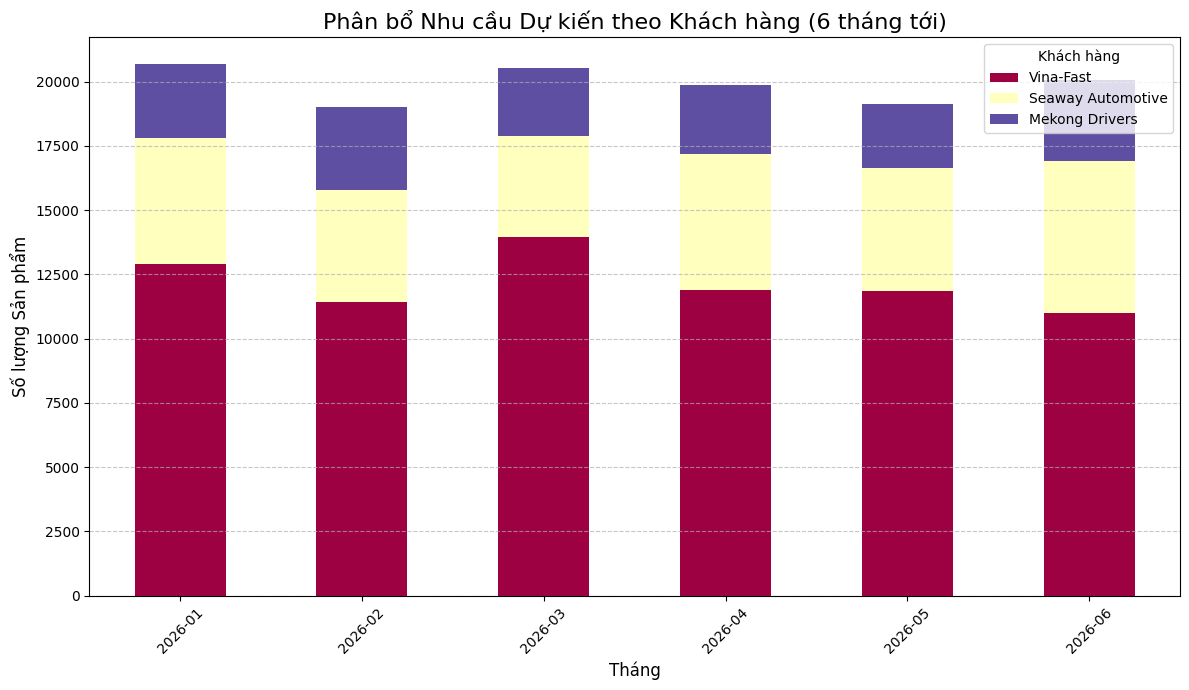

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def project_demand_by_customer_segment(months=6):
    
    # --- THÔNG SỐ NỀN TẢNG 
    TOTAL_AVERAGE_DEMAND = 20000
    
    # Dữ liệu phân bổ khách hàng bạn đã cung cấp
    customer_data = {
        'Customer': ['Vina-Fast', 'Seaway Automotive', 'Mekong Drivers'],
        'Allocation': [0.60, 0.25, 0.15]
    }
    customer_df = pd.DataFrame(customer_data)
    
    # Tính toán nhu cầu trung bình cho từng khách hàng
    customer_df['Average_Demand'] = TOTAL_AVERAGE_DEMAND * customer_df['Allocation']
    
    # Giả định độ biến động (standard deviation) là 10% so với nhu cầu trung bình của mỗi khách hàng
    customer_df['Std_Dev'] = customer_df['Average_Demand'] * 0.10
    
    # --- TẠO KỊCH BẢN MÔ PHỎNG ---
    future_months = pd.to_datetime(pd.Series([f'2026-{i}-01' for i in range(1, months + 1)])).dt.to_period('M')
    
    # np.random.seed(50) # Sử dụng seed để kết quả luôn giống nhau mỗi lần chạy
    
    # Tạo DataFrame kết quả
    projection_list = []
    for month in future_months:
        monthly_demand = {'Tháng': month}
        total_monthly_demand = 0
        
        # Mô phỏng nhu cầu cho từng khách hàng trong tháng đó
        for _, row in customer_df.iterrows():
            customer_name = row['Customer']
            demand = np.random.normal(loc=row['Average_Demand'], scale=row['Std_Dev'])
            demand = int(max(0, demand)) # Đảm bảo nhu cầu không âm
            monthly_demand[customer_name] = demand
            total_monthly_demand += demand
            
        monthly_demand['TỔNG NHU CẦU'] = total_monthly_demand
        projection_list.append(monthly_demand)
        
    projection_df = pd.DataFrame(projection_list)

    print("="*80)
    print("KỊCH BẢN MÔ PHỎNG NHU CẦU CHI TIẾT THEO TỪNG KHÁCH HÀNG (6 THÁNG TỚI)")
    print("="*80)
    print(projection_df.to_string(index=False))
    print("\n" + "="*80)

    # --- VẼ BIỂU ĐỒ TRỰC QUAN HÓA (DẠNG STACKED BAR) ---
    plot_df = projection_df.set_index('Tháng')
    plot_df[['Vina-Fast', 'Seaway Automotive', 'Mekong Drivers']].plot(
        kind='bar', 
        stacked=True, 
        figsize=(12, 7),
        colormap='Spectral'
    )
    
    plt.title('Phân bổ Nhu cầu Dự kiến theo Khách hàng (6 tháng tới)', fontsize=16)
    plt.xlabel('Tháng', fontsize=12)
    plt.ylabel('Số lượng Sản phẩm', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Khách hàng')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    plt.savefig('demand_projection_by_customer.png')
    print("Biểu đồ phân bổ nhu cầu chi tiết đã được lưu vào file 'demand_projection_by_customer.png'")


# Chạy mô phỏng
project_demand_by_customer_segment()